In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
import gget
import sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
import xgi

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

In [2]:
# load the population data
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(193, 122676)


read_code,65057,21695,119867,7453,65998,81009,110088,18720,89300,115287,...,47296,6202,3069,97901,6136,88389,111230,69764,94327,2373
bin,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
break

# Summary Statistics

In [3]:
degrees = df.sum(axis=1)
orders = df.sum(axis=0)

print(f"{degrees.mean()=:.2f}")
print(f"{orders.mean()=:.2f}")

# get the degree of higher order contacts
high_order_idx = np.argwhere(orders.values > 2).ravel()

print("Number of higher-order contacts")
df.columns[high_order_idx].shape

degrees.mean()=1610.08
orders.mean()=2.53
Number of higher-order contacts


(40694,)

# Plot some contacts

Text(0.5, 1.0, 'Sample of 500 Hyperedges from Population Pore-C')

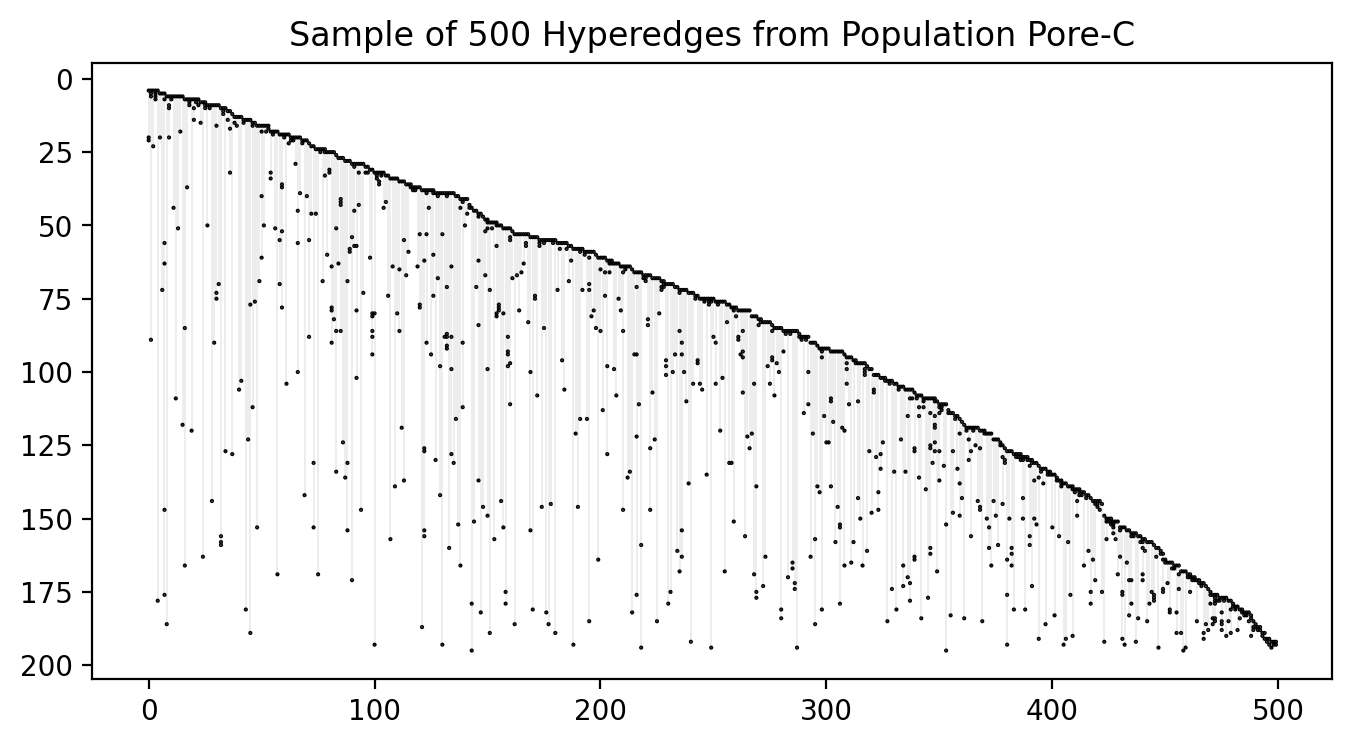

In [4]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(df.T.sample(sample_size).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.title(f"Sample of {sample_size} Hyperedges from Population Pore-C")

# k-m hypercore

In [5]:
# m = 3
# k = 40

# # prepare data
# data = ut.incidence_to_list_of_list(df)
# data = hc.prepare_for_hypercore_decomp(data, k=2)

# # perform decomposition
# mk_hyper = hc.m_k_decomposition(data, m, k)
# print(mk_hyper)

# I = hc.xgi_to_incidence(mk_hyper)
# A = matrix.clique_expand_incidence(I, zero_diag=False)  

# print(f"{I.shape=} {A.shape=}")
# I.head()

In [6]:
# degrees_core = I.sum(axis=1).reset_index()
# degrees_core['bin'] = df.index 
# degrees_core = degrees_core.drop(columns=['index'])
# degrees_core.columns = ['degree_core', 'bin']

# degrees_core.head()

# Load RNA Expression

In [7]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/rna/expression.parquet"
gdf = pd.read_parquet(fpath)

resolution = 1000000

gdf = gdf[gdf['Chromosome'] == "1"]
gdf = gdf[gdf['gene_biotype'] == "protein_coding"]

gdf['TPM'] = gdf['4DNFICXJQ3PA_TPM'] # set this one as "THE ONE"
gdf['log_TPM'] = np.log1p(gdf['TPM']) # set this one as "THE ONE"
gdf['bin'] = gdf['midpoint'].apply(lambda x: ut.bin_loci(x, resolution))

gdf = gdf.sort_values(by='TPM', ascending=False)
print(f"{gdf.shape=}")
gdf.head()

gdf.shape=(1200, 19)


,4DNFI8CSCJWM_TPM,4DNFICXJQ3PA_TPM,4DNFI3YYNDKI_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,4DNFIC269AEU_TPM,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf,TPM,log_TPM,bin
5431,165.41,3779.20,159.55,159.55,165.41,3779.21,ENSMUSG00000026238,Ptma,ensembl_havana,protein_coding,1,86454447,86458434,3987,86456440,False,3779.20,8.237532,87.0
13659,218.15,3199.98,196.70,196.70,218.15,3199.97,ENSMUSG00000046330,Rpl37a,ensembl_havana,protein_coding,1,72750448,72752972,2524,72751710,False,3199.98,8.071212,73.0
20243,98.29,2391.16,89.14,89.14,98.30,2391.15,ENSMUSG00000073702,Rpl31,ensembl_havana,protein_coding,1,39406922,39410992,4070,39408957,False,2391.16,7.779952,40.0
12923,166.14,1669.75,190.79,190.80,166.15,1669.75,ENSMUSG00000043716,Rpl7,ensembl_havana,protein_coding,1,16171518,16174886,3368,16173202,False,1669.75,7.421028,17.0
5428,23.58,1440.18,29.43,29.43,23.60,1440.18,ENSMUSG00000026234,Ncl,ensembl_havana,protein_coding,1,86272440,86287122,14682,86279781,False,1440.18,7.273218,87.0


# Summary of Features by Genomic Loci

Mon Jun 10 15:55:48 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:55:48 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:55:48 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:55:48 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:55:48 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates

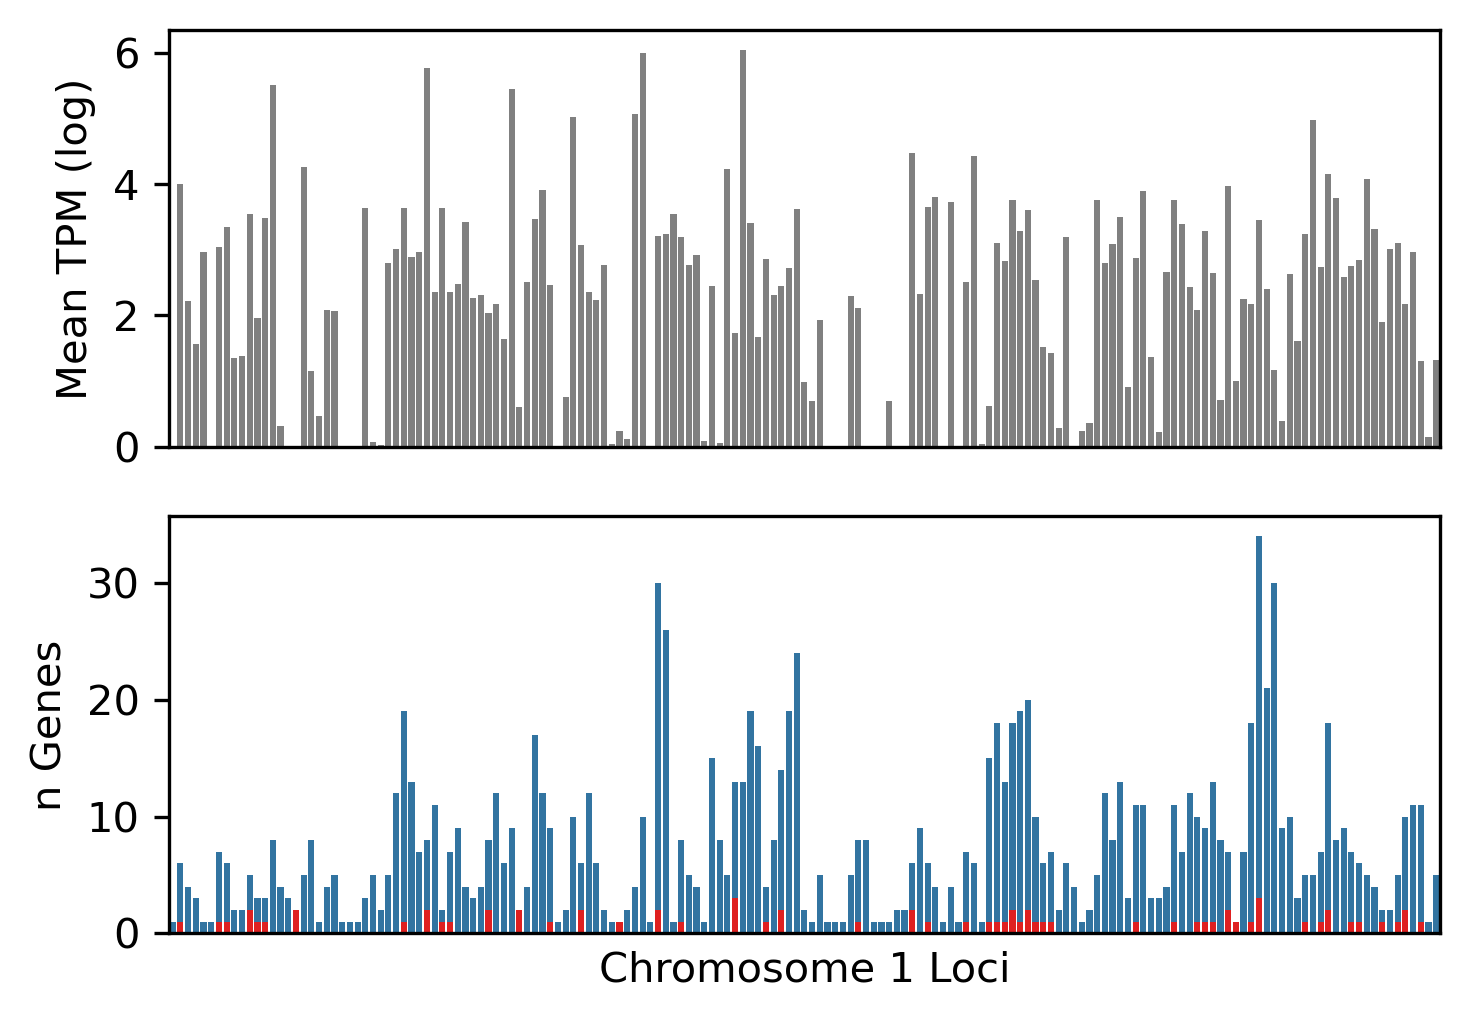

In [8]:
# plot bin level gene stats
gx = gdf.groupby('bin').agg(
    mean_tpm = ('TPM', 'mean'),
    n_genes = ('gene_name', 'count'),
    n_tfs = ('is_tf', 'sum'),
).reset_index()

gx['bin'] = gx['bin'].astype(int)
gx['log_TPM'] = np.log1p(gx['mean_tpm'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3.5

fig, axs = plt.subplots(2, 1, sharex=True)

sns.barplot(data=gx, 
            x='bin', 
            y='log_TPM',
            color='grey',
            ax=axs[0])

sns.barplot(data=gx, 
            x='bin', 
            y='n_genes',
            ax=axs[1])

sns.barplot(data=gx, 
            x='bin', 
            y='n_tfs',
            color='r',
            ax=axs[1]
           )

axs[0].set_ylabel('Mean TPM (log)')
axs[1].set_ylabel('n Genes')
plt.xticks([])
plt.xlabel("Chromosome 1 Loci")

plt.tight_layout()

# Most Highly Expressed

In [9]:
gdf = gdf.sort_values(by='TPM', ascending=False)

database = 'celltypes'
result = gget.enrichr(gdf['gene_name'].head(50).to_list(), database=database)

result.head(5)

Mon Jun 10 15:55:49 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Pluripotent Stem Cells,0.000176,15.975845,138.115084,"[PARP1, NCL, MCM3, HNRNPU]",0.006159,PanglaoDB_Augmented_2021
1,2,Reticulocytes,0.027408,8.188531,29.453626,"[DHX9, MCM3]",0.261280,PanglaoDB_Augmented_2021
2,3,Ionocytes,0.029403,7.875000,27.772490,"[TFCP2L1, ATP1B1]",0.261280,PanglaoDB_Augmented_2021
3,4,Cardiac Stem And Precursor Cells,0.032501,7.447072,25.517254,"[FN1, LAMC1]",0.261280,PanglaoDB_Augmented_2021
4,5,Melanocytes,0.043692,6.303753,19.734490,"[FN1, LAMC1]",0.261280,PanglaoDB_Augmented_2021


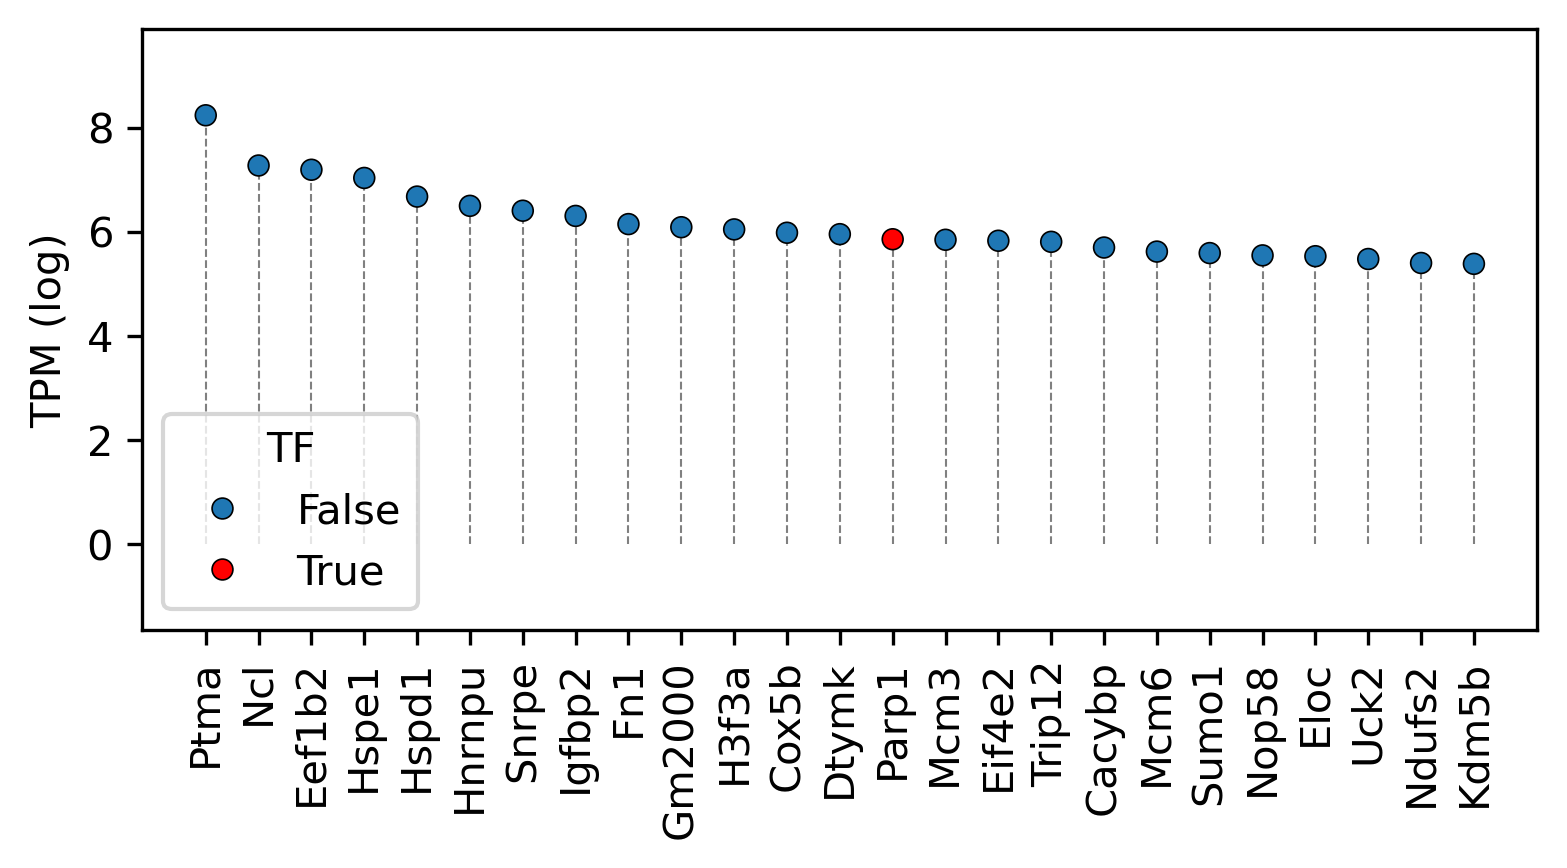

In [10]:
n_genes = 25

esc_genes = [
    'PARP1',
    'NCL',
    'MCM3', 
    'HNRNPU',
    'TERF1',
]

pdf = gdf.copy()
pdf = pdf[~pdf['gene_name'].str.startswith("Rp")]
pdf['gene_name'] = np.where(pdf['gene_name'].isin(esc_genes), "* " + pdf['gene_name'], pdf['gene_name'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2.6

ax = sns.scatterplot(data=pdf.head(n_genes),
            y='log_TPM',
            x='gene_name',
            hue='is_tf',
            ec='k',
            s=25,
            palette=['C0', 'r'], )

# for point in ax.collections[0].get_offsets():  
#     ax.hlines(point[1], 
#               0,
#               point[0], 
#               colors='grey',
#               ls='--',
#               lw=0.5,
#               zorder=0)  
    
for point in ax.collections[0].get_offsets():
    ax.vlines(point[0],  # Use the x-coordinate for the vertical line
              0,         
              point[1],  # Use the y-coordinate as the upper limit
              colors='grey', 
              ls='--', 
              lw=0.5, 
              zorder=0) 

plt.xlabel("")
plt.ylabel("TPM (log)")

plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(ax,  
                loc='lower left',
                title='TF')

plt.margins(y=0.2, x=0.05)

# Gene Summaries

In [11]:
def summarize_gene_data(gdf):
    pdf = gdf.copy()
    nz_mask = pdf['TPM'] > 0
    # Printing overall gene and TF counts with clear formatting
    print("\n--- Overall Counts ---\n")
    print(f"- Total Number of Genes: {pdf['gene_name'].nunique()}")
    print(f"- Number of Genes with TPM > 0: {pdf[nz_mask]['gene_name'].nunique()}")
    print(f"- Total Number of TFs: {pdf['is_tf'].sum()}")
    print(f"- Number of TFs with TPM > 0: {pdf[nz_mask]['is_tf'].sum()}")
    
summarize_gene_data(gdf)


--- Overall Counts ---

- Total Number of Genes: 1197
- Number of Genes with TPM > 0: 896
- Total Number of TFs: 70
- Number of TFs with TPM > 0: 58


In [12]:
print(pdf.groupby('bin')[['TPM']].describe())

        TPM                                                           
      count       mean        std    min    25%    50%     75%     max
bin                                                                   
4.0     1.0   0.020000        NaN   0.02   0.02   0.02   0.020    0.02
5.0     5.0  63.896000  68.133474   0.30   1.91  58.69  96.870  161.71
6.0     4.0   8.250000  16.167098   0.00   0.18   0.25   8.320   32.50
7.0     3.0   3.813333   6.604887   0.00   0.00   0.00   5.720   11.44
8.0     1.0  18.450000        NaN  18.45  18.45  18.45  18.450   18.45
...     ...        ...        ...    ...    ...    ...     ...     ...
191.0   9.0   6.862222   7.822512   0.00   0.94   5.56   9.490   19.70
192.0  11.0  18.421818  18.895474   0.05   3.73  11.35  32.905   58.08
193.0  11.0   2.680000   4.840589   0.00   0.25   1.17   2.495   16.76
194.0   1.0   0.170000        NaN   0.17   0.17   0.17   0.170    0.17
195.0   5.0   2.774000   4.991290   0.00   0.00   0.84   1.390   11.64

[165 

# Expressed TFs

In [13]:
# get the expressed TFs
pdf = gdf.copy()

pdf = gdf.copy()
pdf = pdf[~pdf['gene_name'].str.startswith("RP")]
pdf = pdf[pdf['is_tf']]

print(pdf['gene_name'].unique())

pdf.head(10)

['Parp1' 'Tfcp2l1' 'Usf1' 'Elf3' 'Terf1' 'Rbbp5' 'Ahctf1' 'Vps4b' 'Ccnt2'
 'Gbx2' 'Prdm14' 'Gli2' 'Nr5a2' 'Sox13' 'Pou2f1' 'Creb1' 'Ncoa2' 'Hes6'
 'Taf1a' 'Stat1' 'Elk4' 'Atf3' 'Zbtb18' 'Msc' 'Zbed6' 'Atf6' 'Mybl1'
 'Arid5a' 'Zbtb41' 'Stat4' 'Klf7' 'Zbtb37' 'Sox17' 'Npas2' 'Pbx1' 'Yod1'
 'Satb2' 'Carf' 'Irf6' 'Batf3' 'Tcf24' 'Mixl1' 'Pou3f3' 'En1' 'Ikzf2'
 'Nhlh1' 'Lmx1a' 'Sp100' 'Fev' 'Fhl2' 'Prox1' 'Nr1i3' 'Myog' 'Sp110'
 'Rfx8' 'Sp140' 'Hlx' 'Prrx1' 'Lhx4' 'Ascl5' 'Tfap2d' 'Twist2' 'Pax3'
 'Tbx19' 'Cfap65' 'Tfap2b' 'Esrrg' 'Hsfy2' 'Lhx9' 'Rxrg']


,4DNFI8CSCJWM_TPM,4DNFICXJQ3PA_TPM,4DNFI3YYNDKI_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,4DNFIC269AEU_TPM,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf,TPM,log_TPM,bin
5575,20.55,348.79,19.42,19.42,20.55,348.79,ENSMUSG00000026496,Parp1,ensembl_havana,protein_coding,1,180396488,180428819,32331,180412653,True,348.79,5.857333,181.0
5505,17.68,206.68,11.53,11.53,17.68,206.68,ENSMUSG00000026380,Tfcp2l1,ensembl_havana,protein_coding,1,118555674,118612898,57224,118584286,True,206.68,5.335998,119.0
5661,8.28,121.41,7.06,7.07,8.28,121.40,ENSMUSG00000026641,Usf1,ensembl_havana,protein_coding,1,171238880,171246710,7830,171242795,True,121.41,4.807376,172.0
522,4.86,113.81,7.81,7.81,4.86,113.81,ENSMUSG00000003051,Elf3,ensembl_havana,protein_coding,1,135181312,135186306,4994,135183809,True,113.81,4.743279,136.0
5250,4.42,94.45,5.68,5.68,4.42,94.46,ENSMUSG00000025925,Terf1,ensembl_havana,protein_coding,1,15875869,15914276,38407,15895072,True,94.45,4.558603,16.0
5544,5.76,77.72,6.07,6.08,5.77,77.71,ENSMUSG00000026439,Rbbp5,ensembl_havana,protein_coding,1,132405102,132433397,28295,132419249,True,77.72,4.365897,133.0
5571,9.88,48.18,14.14,14.13,9.88,48.18,ENSMUSG00000026491,Ahctf1,ensembl_havana,protein_coding,1,179572458,179631245,58787,179601851,True,48.18,3.895487,180.0
1278,6.27,45.48,5.81,5.82,6.27,45.48,ENSMUSG00000009907,Vps4b,ensembl_havana,protein_coding,1,106691800,106724458,32658,106708129,True,45.48,3.839022,107.0
5492,6.11,44.13,5.35,5.34,6.12,44.12,ENSMUSG00000026349,Ccnt2,ensembl_havana,protein_coding,1,127701900,127735798,33898,127718849,True,44.13,3.809547,128.0
9692,0.09,40.83,0.15,0.15,0.09,40.83,ENSMUSG00000034486,Gbx2,ensembl_havana,protein_coding,1,89855677,89858901,3224,89857289,True,40.83,3.733614,90.0


n TF with Expression > 5 = 26


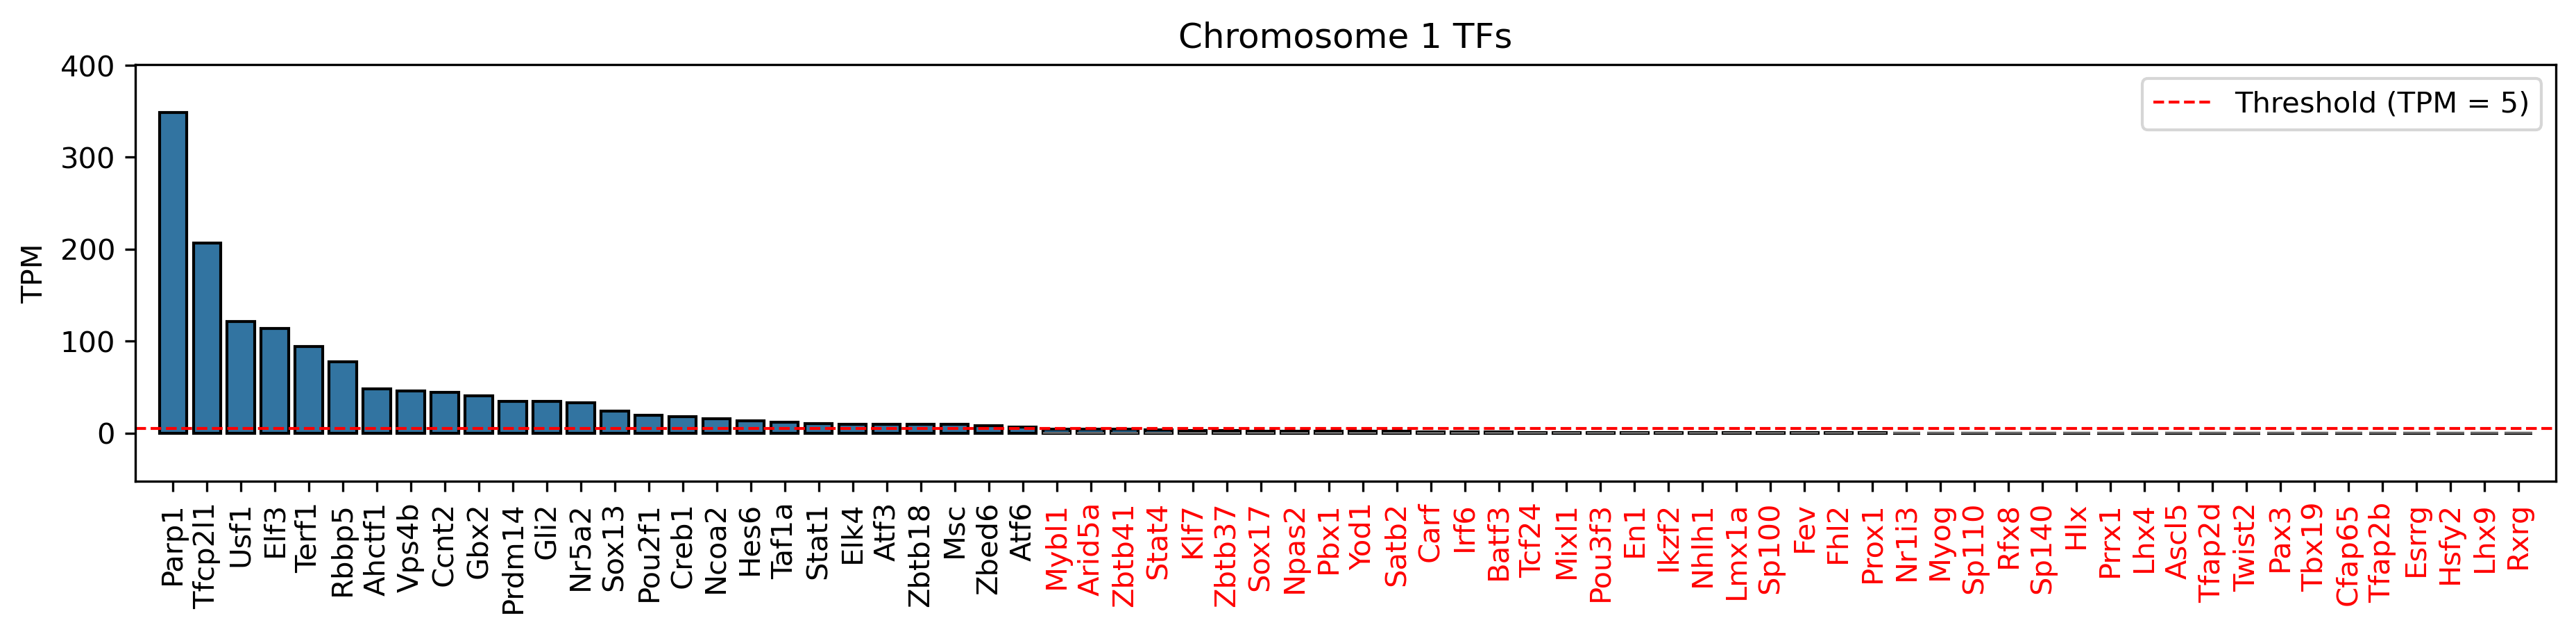

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 2.6

k = 5 
tpm_values = pdf['TPM']

print(f"n TF with Expression > {k} = {pdf[pdf['TPM'] > k].shape[0]}")

ax = sns.barplot(data=pdf, 
           x='gene_name',
           y='TPM',
           ec='k')

# Add a horizontal line at the threshold
plt.axhline(y=k, 
            color='r', 
            linestyle='dashed',
            linewidth=1,
            label=f'Threshold (TPM = {k})')


# Create a legend for the threshold line
plt.legend()

for item in ax.get_xticklabels():
    gene_name = item.get_text()
    tpm_value = pdf.loc[pdf['gene_name'] == gene_name, 'TPM'].values[0]

    if tpm_value < k:
        item.set_color("red")

# Add white patches behind the gene names for better visibility (optional)
for index, gene_name in enumerate(pdf['gene_name']):
    tpm_value = pdf.loc[pdf['gene_name'] == gene_name, 'TPM'].values[0]
    if tpm_value < k:
        # Calculate the x-coordinate for the patch
        x_coord = index - 0.4  # Adjust width and position as needed
        # Add a white rectangle behind the label
        rect = patches.Rectangle((x_coord, -0.2), 0.8, 0.4, linewidth=0, facecolor='white', transform=ax.transData)
        ax.add_patch(rect)

plt.xlabel("")
plt.ylabel("TPM")

plt.title('Chromosome 1 TFs')
plt.gca().tick_params(axis='x', rotation=90)
plt.margins(y=0.15, x=0.01)

# Plot edges between nodes with highly expressed genes

In [15]:
n_genes = 25
t = 1 # the number of gene-bins that need to be in the concatemer to keep

esc_genes = [
    'PARP1',
    'NCL',
    'MCM3', 
    'HNRNPU',
    'TERF1',
]

pdf = gdf.copy()
pdf = pdf[~pdf['gene_name'].str.startswith("Rp")]
pdf['ESC_marker'] = pdf['gene_name'].isin(esc_genes)
pdf = pdf.head(n_genes)

"""Get the unique bins """
gene_bins = pdf['bin'].unique()


gene_hyperedges = df.loc[gene_bins]
print(f"{gene_hyperedges.shape=}")

gene_orders = gene_hyperedges.sum(axis=0)
hyperedge_index = gene_orders[gene_orders >= t].index

Ig = df[hyperedge_index]
print(f"{Ig.shape=}")

gene_hyperedges.shape=(21, 122676)
Ig.shape=(193, 31838)


In [16]:
31838 / 122676

0.259529166259089

In [17]:
pdf[pdf['ESC_marker']]

,4DNFI8CSCJWM_TPM,4DNFICXJQ3PA_TPM,4DNFI3YYNDKI_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,4DNFIC269AEU_TPM,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf,TPM,log_TPM,bin,ESC_marker


Mon Jun 10 15:55:53 2024 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


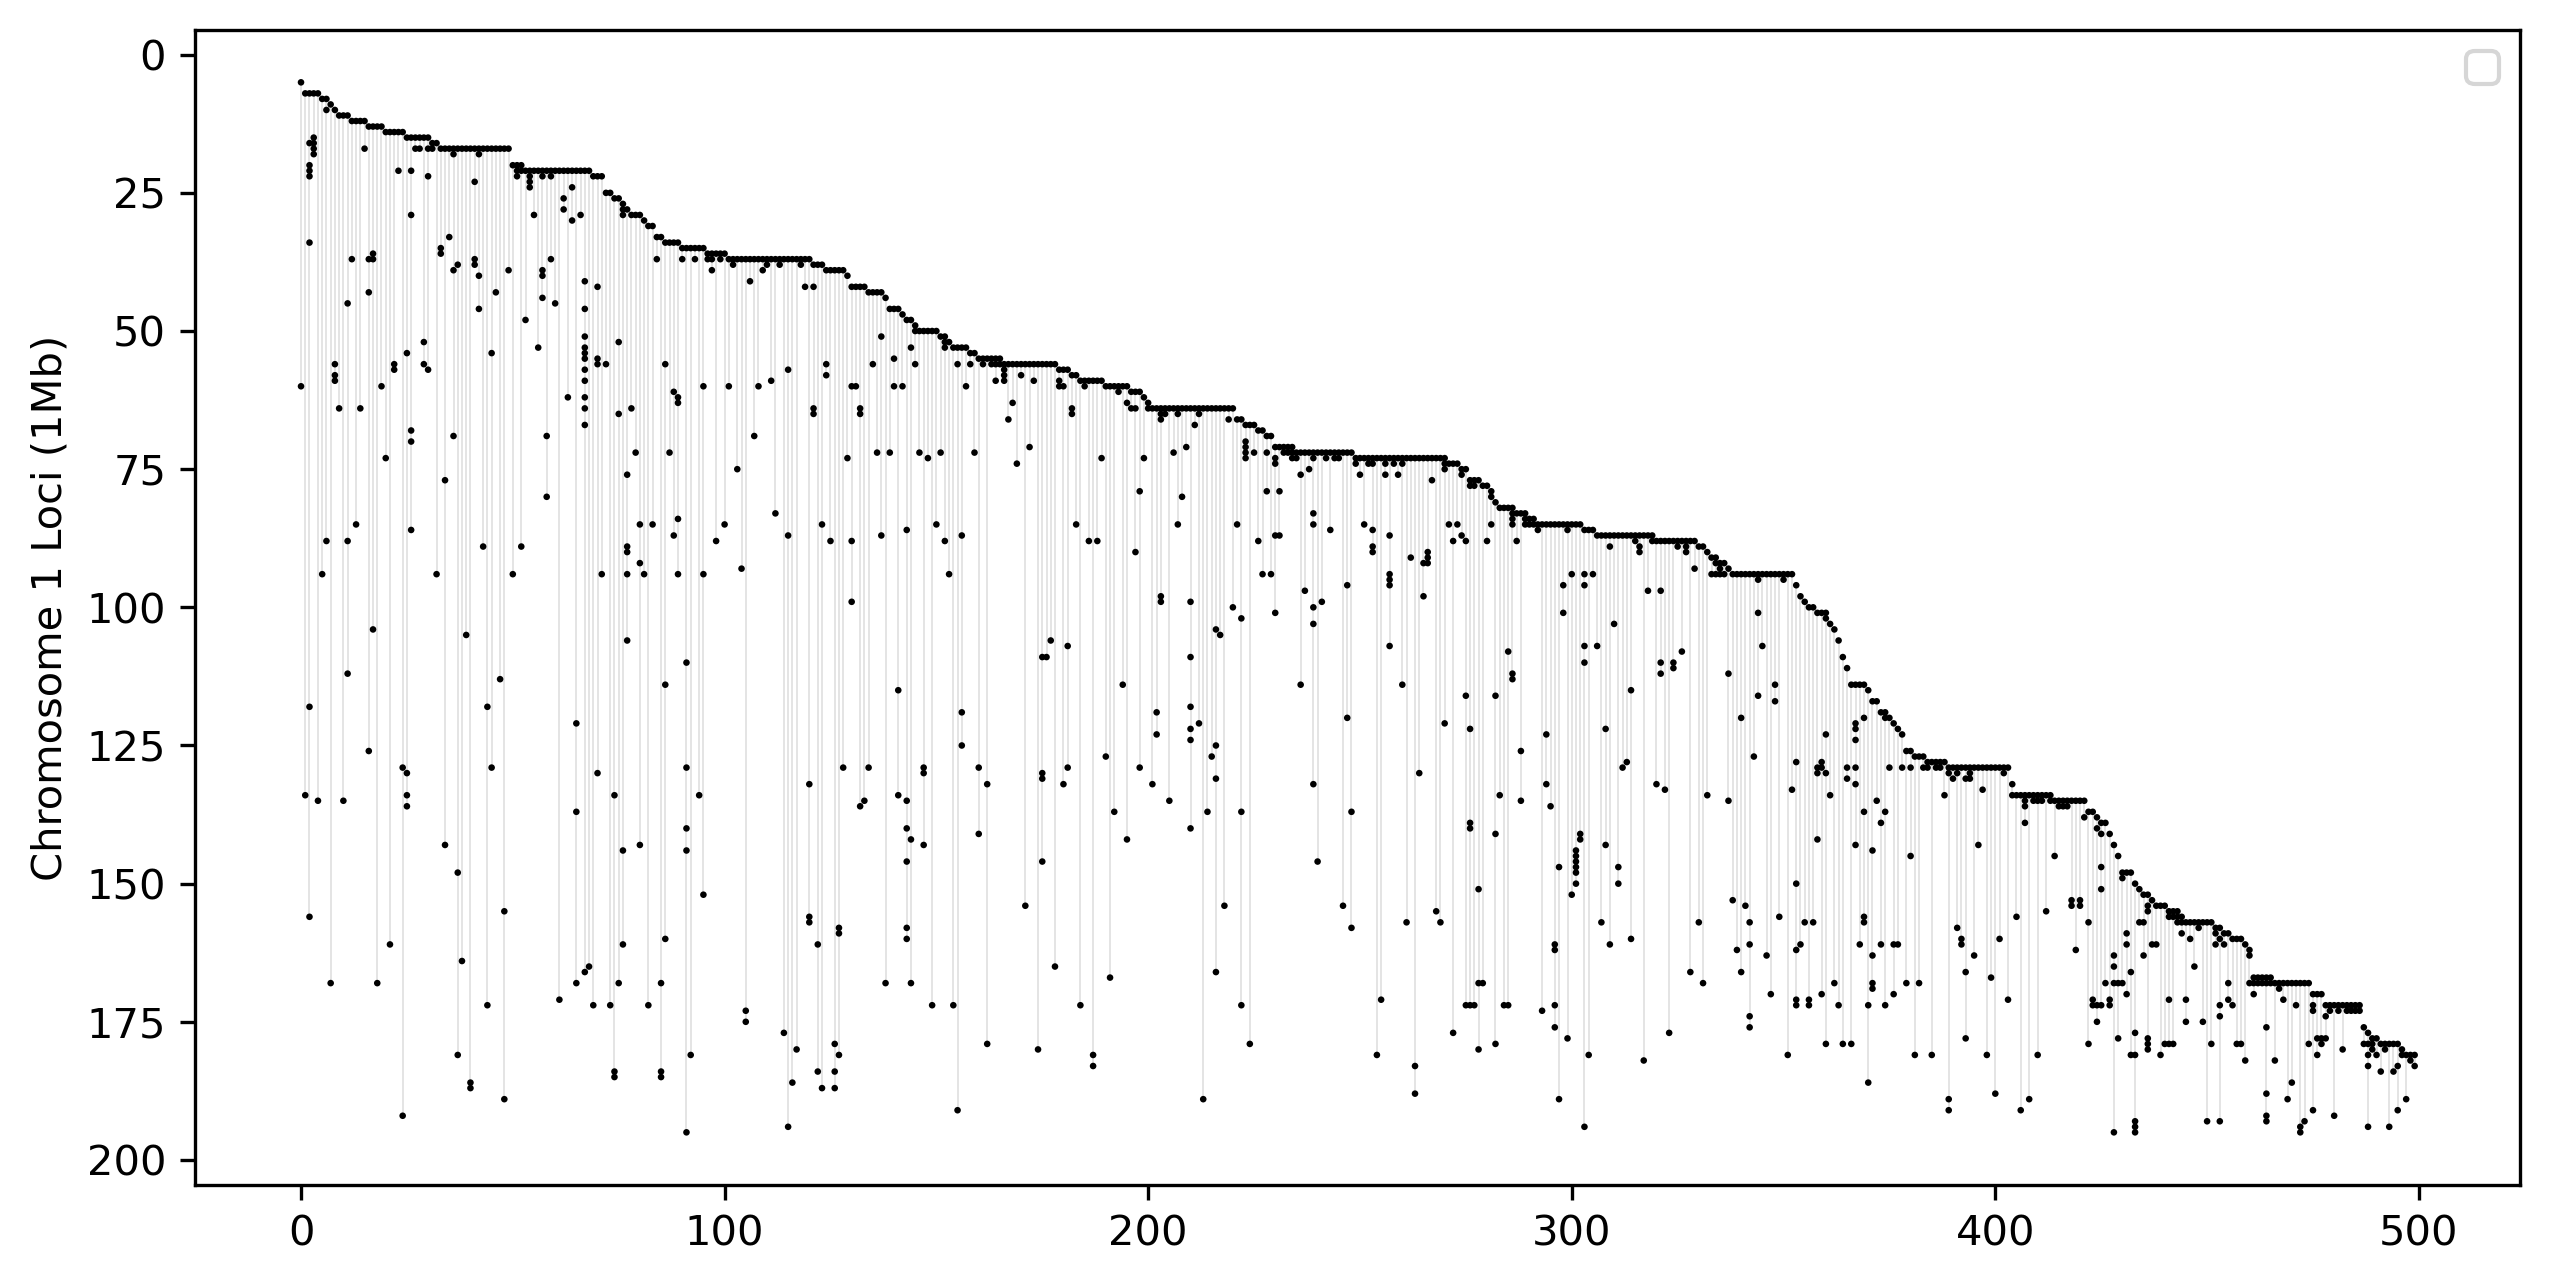

In [18]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

node_params = {
    's' : 10,
    'ec' : 'none',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(Ig.T.sample(sample_size).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.xlabel("")
plt.ylabel("Chromosome 1 Loci (1Mb)")
ax = plt.gca()

# Annotations for the right y-axis
annotate = {
    'NCL' : 'r',
    'HNRNPU' : 'g',
    'MCM3' : 'b',
}

tick_data = pdf[pdf['gene_name'].isin(list(annotate.keys()))]

for _, row in tick_data.iterrows():
    y = row['bin']
    gene = row['gene_name']
    color = annotate[gene]
    ax.axhline(y=y, 
               alpha=0.5,
               lw=3,
               zorder=0, 
               color=color,
               label=gene)
    
plt.legend()

Text(0.5, 191.66666666666657, '')

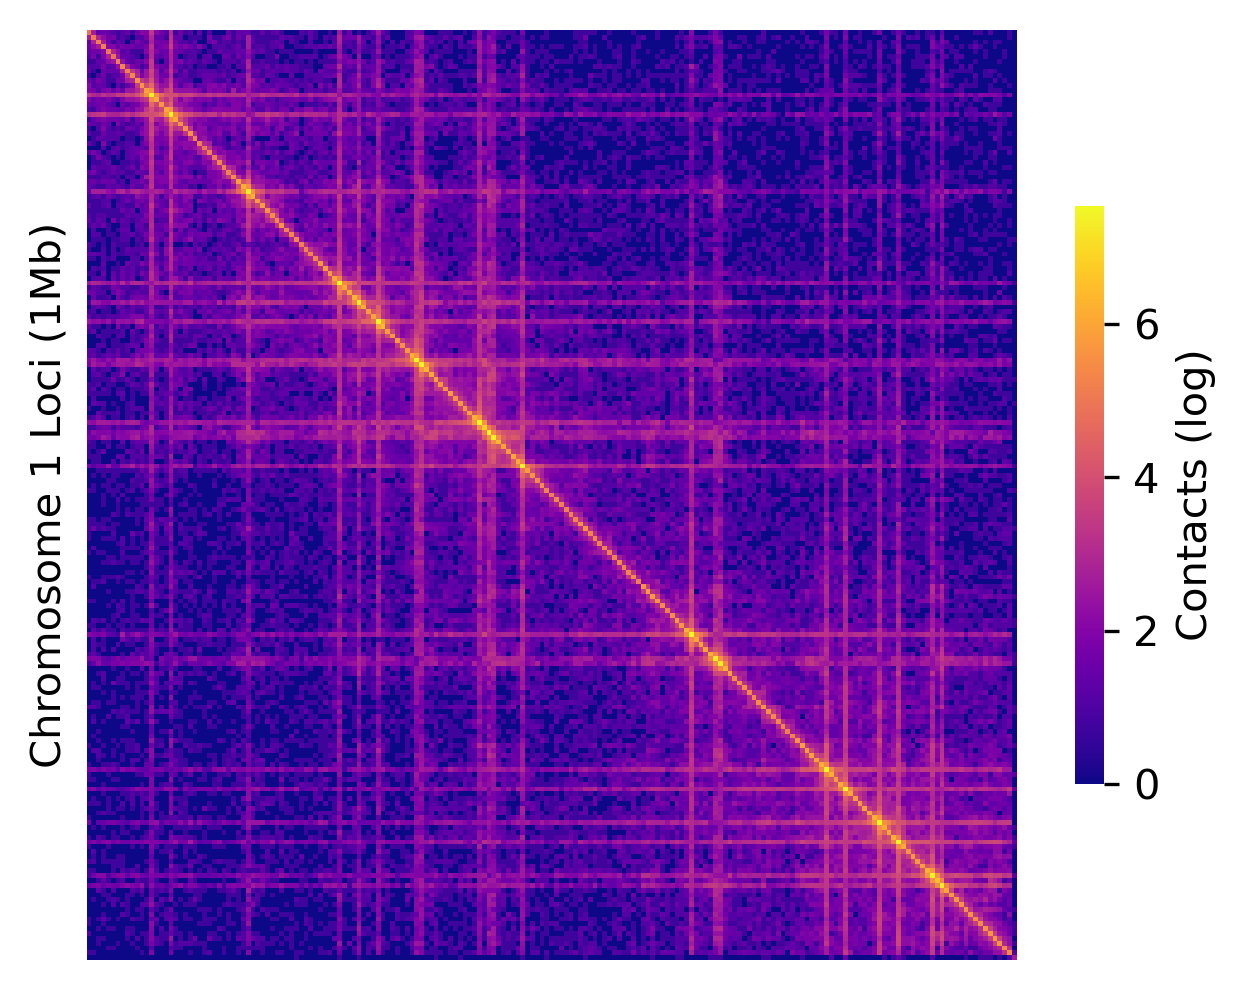

In [19]:
A = matrix.clique_expand_incidence(Ig, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(np.log1p(A), 
            cmap='plasma',
            square=True, 
            cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
           )

plt.yticks([])
plt.xticks([])

plt.ylabel("Chromosome 1 Loci (1Mb)")
plt.xlabel("")

Text(0.5, 191.66666666666657, '')

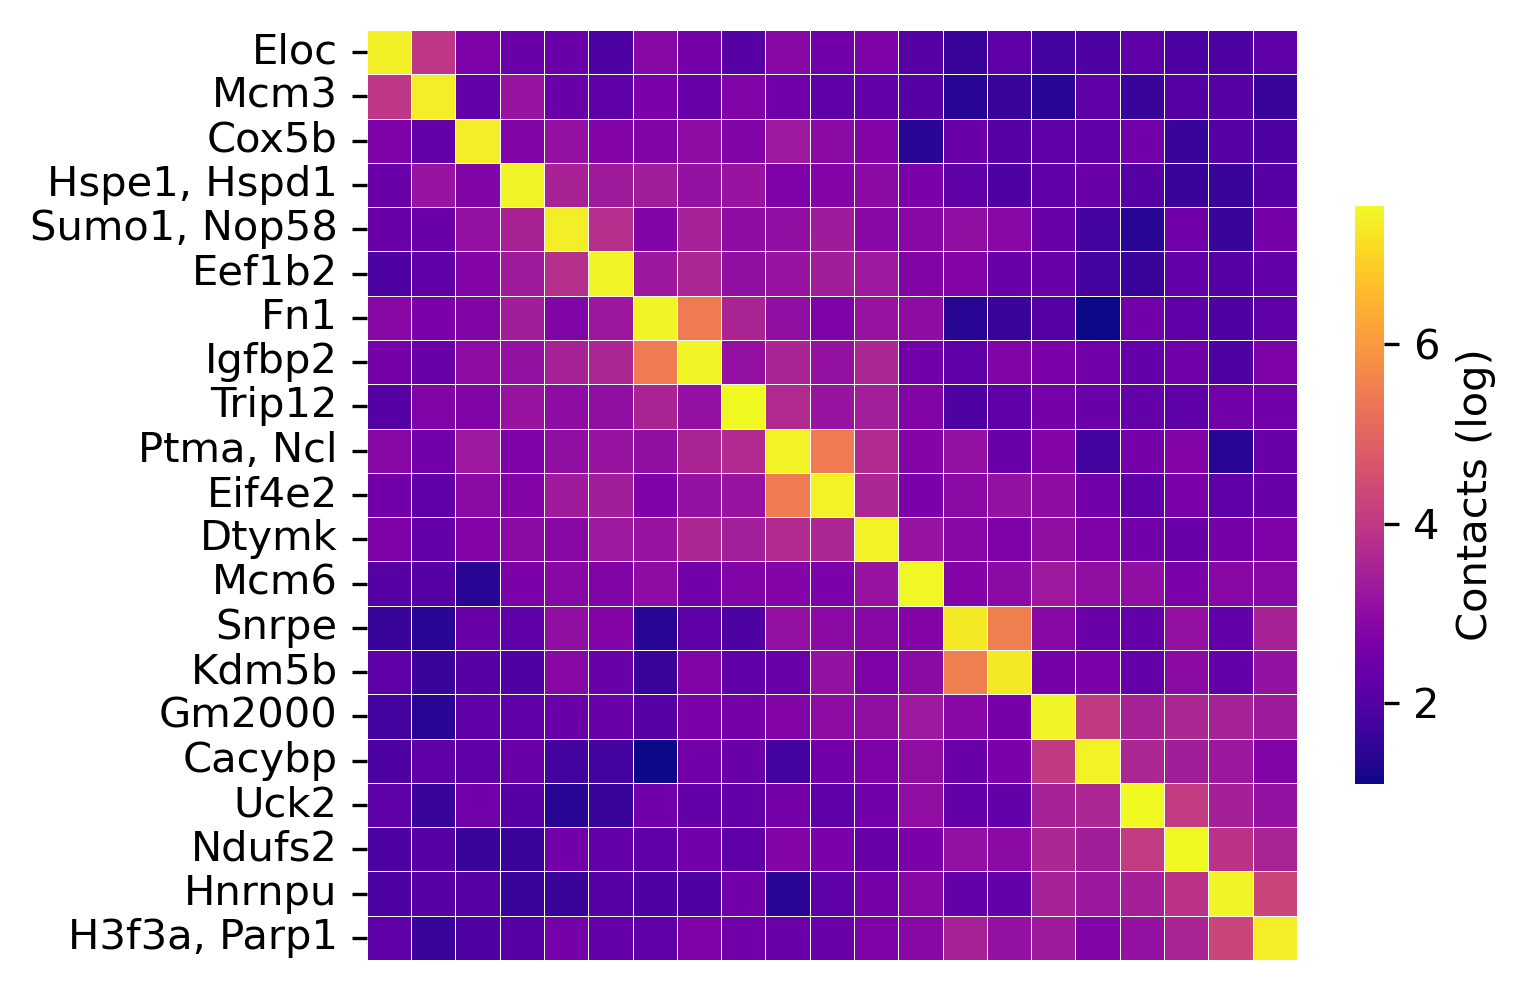

In [20]:
A = matrix.clique_expand_incidence(gene_hyperedges, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

index_map = {bin_val: ', '.join(group['gene_name'].unique()) for bin_val, group in pdf.groupby('bin')}

A = A.rename(index=index_map)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(np.log1p(A), 
            cmap='plasma',
            lw=0.2,
            square=True, 
            cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
           )

# # plt.yticks([])
plt.xticks([])

plt.ylabel("")
plt.xlabel("")

# Hypergraph Centrality

In [21]:
reload(central)

nodes = []

measures = [
    'linear',
    'log-exp', 
    'max',
]

for func in measures:
    
    ncentrality, _ = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
                                                        function=func, 
                                                        maxiter=1000)
    
    nodes.append(pd.DataFrame({func : ncentrality,}, index=df.index))
    
    
nodes = pd.concat(nodes, axis=1).reset_index()
nodes = pd.merge(nodes, gx)

nodes.head()

,bin,linear,log-exp,max,mean_tpm,n_genes,n_tfs,log_TPM
0,4.0,0.002388,0.005107,0.004851,0.020000,1,0,0.019803
1,5.0,0.002916,0.005151,0.005006,53.246667,6,1,3.993542
2,6.0,0.002874,0.005187,0.005009,8.250000,4,0,2.224624
3,7.0,0.003518,0.005222,0.005138,3.813333,3,0,1.571390
4,8.0,0.003023,0.005185,0.005039,18.450000,1,0,2.967847


# plot the hyperedges with the most central nodes

Text(0.5, 191.66666666666657, '')

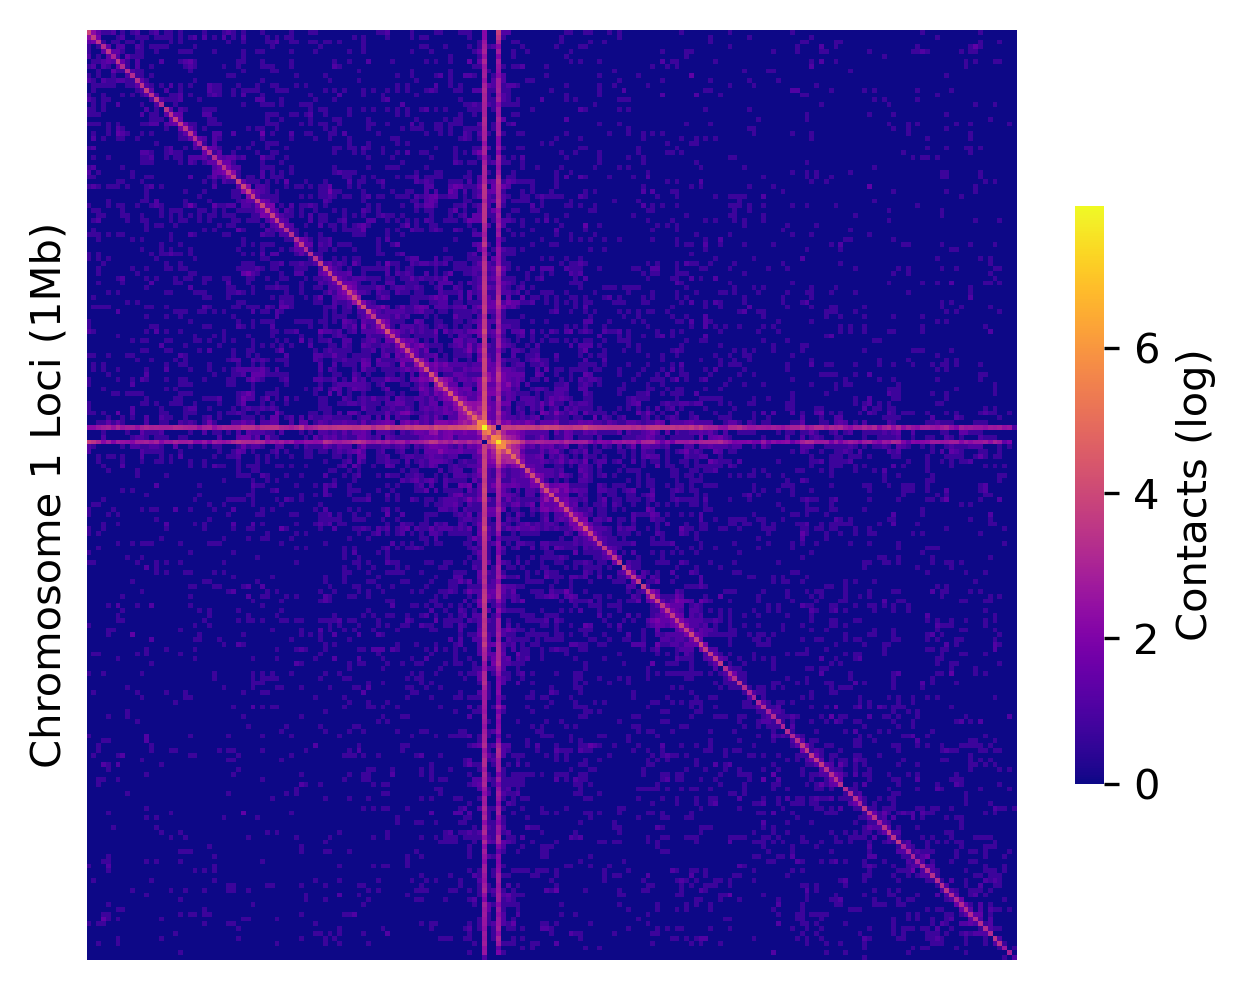

In [22]:
n_top_bins = 2

bins = nodes.sort_values(by='log-exp', ascending=False).head(n_top_bins)['bin'].values
core = df[df.columns[df.loc[bins].sum() == 1]]

A = matrix.clique_expand_incidence(core, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)
# A = matrix.normalize_oe(A)
# A = matrix.normalize_kr(A).todense()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(np.log1p(A), 
            cmap='plasma',
            square=True, 
            cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
            # vmin=0,
            # vmax=0.1,
           )

plt.yticks([])
plt.xticks([])

plt.ylabel("Chromosome 1 Loci (1Mb)")
plt.xlabel("")

# Correlation with expression

In [23]:
table = nodes.set_index('bin').corr()
table = table.loc[measures]
table = table.drop(columns=measures + ['mean_tpm']).reset_index()
table = table[['index','log_TPM', 'n_genes', 'n_tfs']]

print(table.round(3).astype(str).to_latex(index=False))

\begin{tabular}{llll}
\toprule
index & log_TPM & n_genes & n_tfs \\
\midrule
linear & 0.216 & 0.238 & 0.236 \\
log-exp & 0.532 & 0.413 & 0.355 \\
max & 0.394 & 0.303 & 0.268 \\
\bottomrule
\end{tabular}



In [24]:
reload(central)
nodes, hyperedges = central.nonlinear_eigenvector_centrality(df.to_numpy(), function='log-exp', maxiter=1000)

nodes = pd.DataFrame({
    'bin' : df.index,
    'centrality' : nodes,
})

nodes['standardized_centrality'] = (nodes['centrality'] - nodes['centrality'].mean()) / nodes['centrality'].std()

nodes = pd.merge(nodes, gx)

cent2tpm = scipy.stats.pearsonr(nodes['centrality'], 
                                nodes['log_TPM'],
                               )

cent2genes = scipy.stats.pearsonr(nodes['centrality'], 
                                nodes['n_genes'],
                               )

cent2tfs = scipy.stats.pearsonr(nodes['centrality'], 
                                nodes['n_tfs'],
                               )

print(f"Centrality vs. Expression: r={cent2tpm[0]:.3f} (p={cent2tpm[1]:.3f})")
print(f"Centrality vs. n Genes: r={cent2genes[0]:.3f} (p={cent2genes[1]:.3f})")
print(f"Centrality vs. n TFs: r={cent2tfs[0]:.3f} (p={cent2tfs[1]:.3f})")

Centrality vs. Expression: r=0.532 (p=0.000)
Centrality vs. n Genes: r=0.413 (p=0.000)
Centrality vs. n TFs: r=0.355 (p=0.000)


Mon Jun 10 15:56:03 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:03 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:03 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:03 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:04 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates

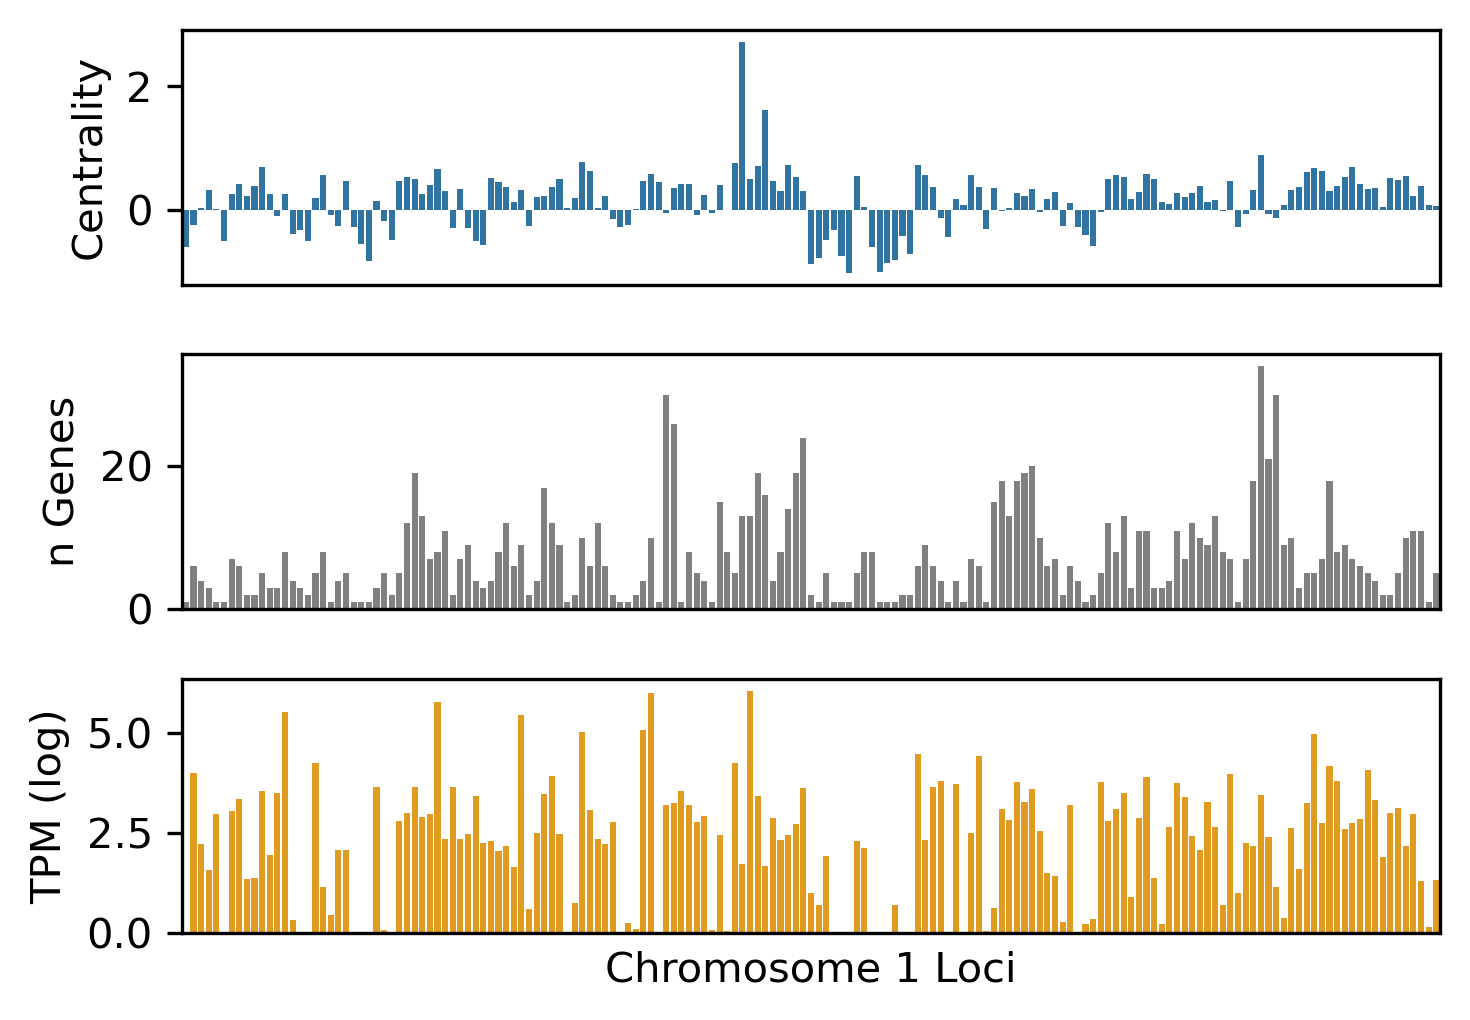

In [25]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3.5

fig, axs = plt.subplots(3, 1, sharex=True)

sns.barplot(data=nodes, 
            x='bin',
            y='standardized_centrality',
            ax=axs[0])

sns.barplot(data=nodes, 
            x='bin', 
            y='n_genes',
            color='grey',
            ax=axs[1])


sns.barplot(data=nodes, 
            x='bin', 
            y='log_TPM',
            color='orange',
            ax=axs[2])

axs[0].set_ylabel('Centrality')
axs[1].set_ylabel('n Genes')
axs[2].set_ylabel('TPM (log)')
plt.xticks([])
plt.xlabel("Chromosome 1 Loci")

plt.tight_layout()


In [26]:
# break

In [27]:
# compare against population Hi-C

reload(matrix)
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_hic/chr1_1000000.parquet"

hic = pd.read_parquet(fpath)
A = hic.to_numpy()
print(f"{A.shape=}")

# drop the telomere
A = A[3:, :][:, 3:]
print(f"{A.shape=}")

Anorm = matrix.normalize_oe(matrix.normalize_kr(A).todense())

# correct outliers
top = 10
row_idx, col_idx = matrix.get_sorted_upper_triangle_indices(Anorm)

# update the matrix 
for i in range(top):
    Anorm[row_idx[i], col_idx[i]] = Anorm.mean()

print(f"{A.shape=}")

A.shape=(196, 196)
A.shape=(193, 193)
A.shape=(193, 193)


/home/cstansbu/git_repositories/higher-order-single-cell/source/matrix.py:146: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = np.divide(matrix, toeplitz_matrix)
/tmp/ipykernel_156181/3314302328.py:11: RuntimeWarning: invalid value encountered in log1p
  plt.plot(np.log1p(eigenvalues_hic), label='Hi-C')
/tmp/ipykernel_156181/3314302328.py:12: RuntimeWarning: invalid value encountered in log1p
  plt.plot(np.log1p(eigenvalues_pc), label='Pore-C')


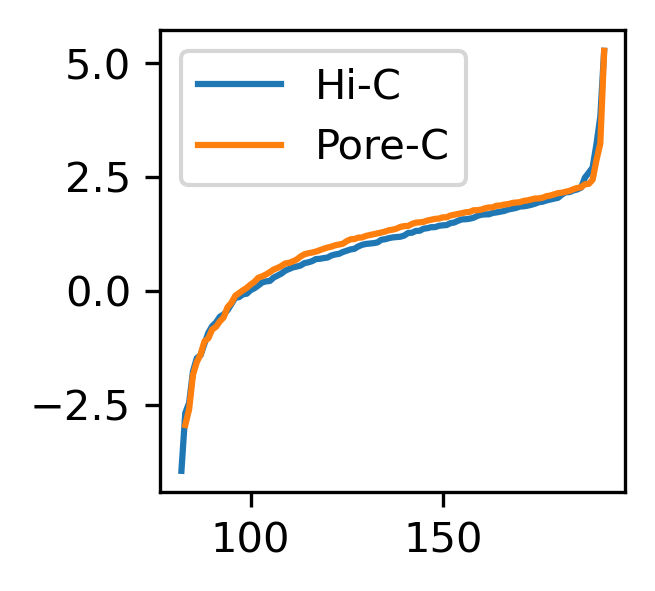

In [28]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2

Aporec = matrix.clique_expand_incidence(df, zero_diag=False) 
Aporec = matrix.normalize_oe(matrix.normalize_kr(Aporec).todense())

eigenvalues_pc, eigenvectors_pc = np.linalg.eigh(Aporec)
eigenvalues_hic, eigenvectors_hic = np.linalg.eigh(Anorm)


plt.plot(np.log1p(eigenvalues_hic), label='Hi-C')
plt.plot(np.log1p(eigenvalues_pc), label='Pore-C')

plt.legend()

In [29]:
reload(central)
nodes, hyperedges = central.nonlinear_eigenvector_centrality(df.to_numpy(), function='log-exp', maxiter=1000)

nodes = pd.DataFrame({
    'bin' : df.index,
    'centrality' : nodes,
    'eigenvector_hic' : -1 * np.ravel(eigenvectors_hic[:, -1]),
    'eigenvector_pc' :  -1 * np.ravel(eigenvectors_pc[:, -1]),
})

nodes['pore_c'] = (nodes['centrality'] - nodes['centrality'].mean()) / nodes['centrality'].std()
nodes['pore_c_clique'] = (nodes['eigenvector_pc'] - nodes['eigenvector_pc'].mean()) / nodes['eigenvector_pc'].std()
nodes['hi_c'] = (nodes['eigenvector_hic'] - nodes['eigenvector_hic'].mean()) / nodes['eigenvector_hic'].std()

nodes[['pore_c', 'pore_c_clique', 'hi_c']].head(192).corr()

,pore_c,pore_c_clique,hi_c
pore_c,1.000000,0.654618,0.455471
pore_c_clique,0.654618,1.000000,0.672062
hi_c,0.455471,0.672062,1.000000


Mon Jun 10 15:56:07 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:07 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:07 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:07 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Mon Jun 10 15:56:08 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates

Text(0.5, 0, 'Chromosome 1 Loci')

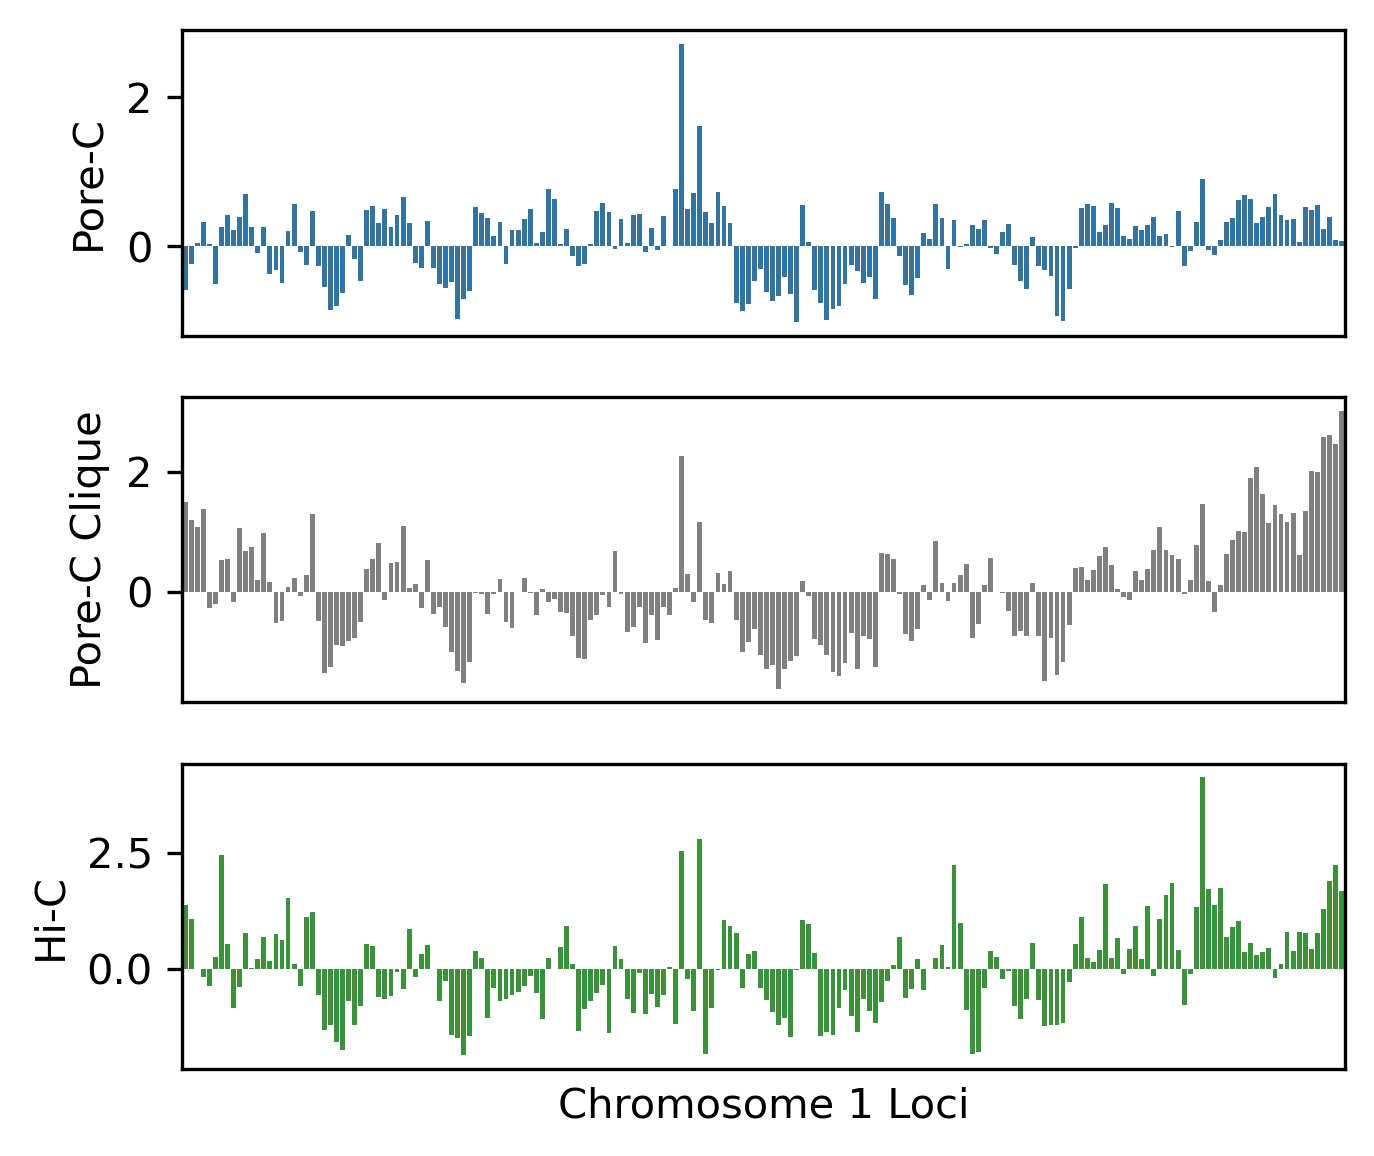

In [30]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4.5

fig, axs = plt.subplots(3, 1, sharex=True)

sns.barplot(data=nodes.head(192), 
            x='bin',
            y='pore_c',
            ax=axs[0])


sns.barplot(data=nodes.head(192), 
            x='bin', 
            y='pore_c_clique',
            color='grey',
            ax=axs[1])

sns.barplot(data=nodes.head(192), 
            x='bin', 
            y='hi_c',
            color='C2',
            ax=axs[2])

axs[0].set_ylabel('Pore-C')
axs[1].set_ylabel('Pore-C Clique')
axs[2].set_ylabel('Hi-C')
plt.xticks([])
plt.xlabel("Chromosome 1 Loci")

# what is highly central?

In [31]:
n_top_bins = 10
n_genes = 100

bins = nodes.sort_values(by='pore_c', ascending=False).head(n_top_bins)['bin'].values
genes = gdf[gdf['bin'].isin(bins) & gdf['is_tf']].head(n_genes)
print(f"{genes.shape=}")

genes['gene_name'].values

# result.head(5)

genes.shape=(13, 19)


array(['Tfcp2l1', 'Usf1', 'Prdm14', 'Gli2', 'Ncoa2', 'Hes6', 'Taf1a',
       'Nhlh1', 'Sp100', 'Nr1i3', 'Sp110', 'Sp140', 'Twist2'],
      dtype=object)

In [32]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Relation to Expression

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/rna/expression.parquet"
gdf = pd.read_parquet(fpath)

resolution = 1000000

gdf = gdf[gdf['Chromosome'] == "1"]
gdf = gdf[gdf['gene_biotype'] == "protein_coding"]
gdf['bin'] = gdf['midpoint'].apply(lambda x: ut.bin_loci(x, resolution))

edf = gdf.groupby('bin').agg(
    # GENE_COUNT = ('gene_name', 'count'),
    # TF_COUNT = ('is_tf', 'sum'),
    TPM_4DNFI8CSCJWM = ('4DNFI8CSCJWM_TPM', 'mean'), 
    TPM_4DNFICXJQ3PA = ('4DNFICXJQ3PA_TPM', 'mean'), 
    TPM_4DNFI3YYNDKI = ('4DNFI3YYNDKI_TPM', 'mean'), 
    TPM_4DNFIPYGE7JR = ('4DNFIPYGE7JR_TPM', 'mean'), 
    TPM_4DNFIYTCHMIZ = ('4DNFIYTCHMIZ_TPM', 'mean'), 
    TPM_4DNFIC269AEU = ('4DNFIC269AEU_TPM', 'mean'), 
).reindex(list(range(3, 196))).fillna(0)
edf = np.log1p(edf)


edf = pd.merge(edf.reset_index(), nodes)

print(f"{edf.shape=}")
edf = edf.set_index('bin')
edf.head()

In [ ]:
measures = ['pore_c', 'pore_c_clique', 'hi_c']
expression = [x for x in edf.columns if "TPM" in x]

correlation = edf.corr().loc[measures][expression].T
correlation.columns = ['Pore-C', 'Pore-C (Clique)', 'Hi-C']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 4

sns.heatmap(data=correlation,
            annot=True,
            cmap='coolwarm',
            lw=1,
            cbar_kws={'shrink' : 0.5, 'label'  : 'Correlation'})


# Other features

In [ ]:
# structure the features
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/1D_features/"
resolution = "1000000"

features = []
for f in os.listdir(dpath):
    if not resolution in f:
        continue
        
    if "RNA" in f:
        continue
    dtype = f.split("_")[0]
    fpath = f"{dpath}{f}"
    fdf = pd.read_parquet(fpath)
    fdf = fdf.set_index('index')
    fdf.columns = [f"{dtype}_{x}" for x in fdf.columns]
    features.append(fdf)

features = pd.concat(features, axis=1)
features = features.reset_index(names='bin')
features = features.sort_index()

features = pd.merge(features, nodes)

features = features.set_index('bin')
print(f"{features.shape}")

features.head()


In [ ]:
measures = ['pore_c', 'pore_c_clique', 'hi_c']
expression = [x for x in features.columns if "4DN" in x]

correlation = features.corr().loc[measures][expression].T
correlation.columns = ['Pore-C', 'Pore-C (Clique)', 'Hi-C']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 4

sns.heatmap(data=correlation,
            annot=True,
            cmap='coolwarm',
            lw=1,
            cbar_kws={'shrink' : 0.5, 'label'  : 'Correlation'})

In [ ]:
# who is the max bin?
nodes[nodes['pore_c'] == nodes['pore_c'].max()]

In [ ]:
gdf[gdf['bin'].isin([86.0, 87.0])]

In [ ]:
break

# Node Clustering

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/rna/expression.parquet"
gdf = pd.read_parquet(fpath)

resolution = 1000000

gdf = gdf[gdf['Chromosome'] == "1"]
gdf = gdf[gdf['gene_biotype'] == "protein_coding"]
gdf['bin'] = gdf['midpoint'].apply(lambda x: ut.bin_loci(x, resolution))

renamer = {
    '4DNFI8CSCJWM_TPM' :  'TPM_4DNFI8CSCJWM' , 
    '4DNFICXJQ3PA_TPM' :  'TPM_4DNFICXJQ3PA' , 
    '4DNFI3YYNDKI_TPM' :  'TPM_4DNFI3YYNDKI' , 
    '4DNFIPYGE7JR_TPM' :  'TPM_4DNFIPYGE7JR' , 
    '4DNFIYTCHMIZ_TPM' :  'TPM_4DNFIYTCHMIZ' , 
    '4DNFIC269AEU_TPM' :  'TPM_4DNFIC269AEU' ,
}

gdf = gdf.rename(columns=renamer)

# agregate over bins

edf = gdf.groupby('bin').agg(
    # GENE_COUNT = ('gene_name', 'count'),
    # TF_COUNT = ('is_tf', 'sum'),
    TPM_4DNFI8CSCJWM = ('TPM_4DNFI8CSCJWM', 'mean'), 
    TPM_4DNFICXJQ3PA = ('TPM_4DNFICXJQ3PA', 'mean'), 
    TPM_4DNFI3YYNDKI = ('TPM_4DNFI3YYNDKI', 'mean'), 
    TPM_4DNFIPYGE7JR = ('TPM_4DNFIPYGE7JR', 'mean'), 
    TPM_4DNFIYTCHMIZ = ('TPM_4DNFIYTCHMIZ', 'mean'), 
    TPM_4DNFIC269AEU = ('TPM_4DNFIC269AEU', 'mean'), 
).reindex(list(range(3, 196))).fillna(0)

print(f"{edf.shape=}")
edf.head()

In [ ]:
reload(central)

nodes = []


function_map = {
    'identity' : [lambda x: x] * 4,
    'square' : [lambda x: x**2] * 4,
    'log1p' : [lambda x: np.log1p(x)] * 4,
    'sqrt' : [lambda x: np.sqrt(x)] * 4,
}

for label, functions in function_map.items():
    
    f, g, phi, psi = functions
    
    ncentrality, _ = central.nl_centrality_func(df.to_numpy(), f, g, phi, psi,  maxiter=1000)
    nodes.append(pd.DataFrame({label : ncentrality,}, index=df.index))
    
    
nodes = pd.concat(nodes, axis=1).reset_index()
nodes.head()

In [ ]:
sns.pairplot(data=nodes.set_index('bin'))

In [ ]:
columns = [
    'ATAC_4DNFIPVAKPXA',
    'ATAC_4DNFIXT1TVT4', 
    'ATAC_4DNFI3ARZKH6',
    'CTCF_4DNFIFFXFV82', 
    'H3K27me3_4DNFI7UN2C36', 
    # 'RNA_4DNFI12AUKQS',
    # 'RNA_4DNFIUW8CG2I', 
    'RNA_4DNFIFVPB94O', 
    'RNA_4DNFIXOTRTRM',
    'RNA_4DNFI4XVSIFH', 
    'RNA_4DNFIW5IZKYG', 
    'H3K27ac_4DNFIXE23VC7',
]

X = features[columns]
X = X[X.index > 2]

X = pd.merge(X, edf, how='left', 
            left_index=True,
            right_index=True)

print(f"{X.shape=}")


scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

new_col_names = [x.split("_")[0] for x in X.columns]

X_scaled = pd.DataFrame(X_scaled, columns=new_col_names, index=X.index)
X_scaled = X_scaled.fillna(0)

Z = linkage(X_scaled, method='ward')

max_d = 0.1

clusters = fcluster(Z, max_d, criterion='distance')
row_colors = clusters
row_colors = plt2.floats_to_colors(row_colors, colormap='Accent')

sns.clustermap(data=X_scaled,
               standard_scale=0,
               row_colors=row_colors,
               row_linkage=Z,
               figsize=(7, 7),
               vmin=0,
               vmax=1,
               cmap='coolwarm',
               col_cluster=False)

plt.ylabel("")

In [ ]:
# measures = [
#     # 'linear',
#     'log-exp', 
#     # 'max',
# ]

# for func in measures:
#     ncentrality, _ = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
#                                                               function=func, 
#                                                               maxiter=1000)
#     features[func] = ncentrality
    
# print(f"{features.shape=}")

In [ ]:
# rna_features = [x for x in features.columns if "RNA" in x]
# print(rna_features)
# sns.pairplot(features[rna_features])

In [ ]:
# sns.pairplot(features)

In [ ]:
pdf = features.copy()
pdf = pdf.head(192)

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(pdf)
pdf = pd.DataFrame(X_scaled, columns=pdf.columns, index=pdf.index)


pdf = pdf.reset_index()
pdf = pd.melt(pdf, id_vars='bin')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3

sns.lineplot(data=pdf, 
             x='bin',
             y='value',
             lw=0.5,
             palette='tab20',
             hue='variable',
            )


sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

In [ ]:
X = features.fillna(0).copy()
X = X.head(192)

# Standardize the features
# scaler = StandardScaler()
scaler = sklearn.preprocessing.Normalizer()

X_scaled = scaler.fit_transform(X)



Z = linkage(X_scaled, method='ward')

max_d = 2
clusters = fcluster(Z, max_d, criterion='distance')
row_colors = clusters
row_colors = plt2.floats_to_colors(row_colors, colormap='Accent')

sns.clustermap(data=features,
               standard_scale=1,
               row_colors=row_colors,
               row_linkage=Z,
               figsize=(3.5, 6),
               # cbar=False,
               cbar_pos=None,
               cmap='plasma',
               col_cluster=False)

plt.ylabel("")

In [ ]:
break

# Weighted Centrality

In [ ]:
node_weights = pd.DataFrame(df.index)

node_weights = pd.merge(node_weights, gx, 
                        how='left',
                        left_on='bin',
                        right_on='bin')

node_weights = node_weights.fillna(0)

print(f"{node_weights.shape=}")

weight_vector = node_weights['log_TPM'].values.reshape(-1, 1)
print(f"{weight_vector.shape=}")

# print(node_weights.shape)
nodes, _ = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
                                                    function='linear',
                                                    maxiter=1000,
                                                    node_weights=weight_vector)
node_weights['w_centrality'] = nodes.ravel()
node_weights.head()       

# Node Clustering

In [ ]:
pdf = node_weights.set_index('bin').copy()

pdf.columns = ['mean_tpm', 'Genes', 'TFs', 'TPM', 'Centrality']
pdf = pdf.drop(columns=['mean_tpm', 'TFs'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pdf)
Z = linkage(X_scaled, method='ward')

max_d = 7
clusters = fcluster(Z, max_d, criterion='distance')
row_colors = clusters
row_colors = plt2.floats_to_colors(row_colors, colormap='Accent')

sns.clustermap(data=pdf,
               standard_scale=1,
               row_colors=row_colors,
               row_linkage=Z,
               figsize=(3.5, 6),
               # cbar=False,
               cbar_pos=None,
               cmap='plasma',
               col_cluster=False)

plt.ylabel("")

In [ ]:
pdf.iloc[np.argwhere(clusters == 2).ravel()]

In [ ]:
genes = gdf[gdf['bin'].isin(pdf[pdf['Centrality'] == pdf['Centrality'].max()].index)]

print(genes[['gene_name', 'midpoint', 'log_TPM']])

database = 'ontology'
result = gget.enrichr(genes['gene_name'].to_list(), database=database)

result.head(5)


In [ ]:
genes = gdf[gdf['bin'].isin(pdf.iloc[np.argwhere(clusters == 2).ravel()].index)]

print(genes[['gene_name', 'midpoint', 'log_TPM']])

database = 'ontology'
result = gget.enrichr(genes['gene_name'].head(10).to_list(), database=database)

result.head(5)

In [ ]:
# extract this "core"
t = 1 # the number of gene-bins that need to be in the concatemer to keep

"""Get the unique bins """
gene_bins = pdf.iloc[np.argwhere(clusters == 2).ravel()].index

gene_hyperedges = df.loc[gene_bins]
print(f"{gene_hyperedges.shape=}")

gene_orders = gene_hyperedges.sum(axis=0)
hyperedge_index = gene_orders[gene_orders >= t].index

Ig = df[hyperedge_index]
print(f"{Ig.shape=}")

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

node_params = {
    's' : 10,
    'ec' : 'none',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

sample_size = 100
plt2.plot_incidence(ut.sort_by_lowest_index(Ig.T.sample(sample_size).T), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.xlabel("")
plt.ylabel("Chromosome 1 Loci (1Mb)")
ax = plt.gca()

In [ ]:
break

# k-m Core decomposition

In [ ]:
m = 3
k = 450

# prepare data
data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

# perform decomposition
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")

In [ ]:
function = 'log-exp'
maxiter = 1000

full_centrality, _ = central.nonlinear_eigenvector_centrality(df.to_numpy(), 
                                                              function=function, 
                                                              maxiter=maxiter)

core_centrality, _ = central.nonlinear_eigenvector_centrality(ut.fill_missing_bins(I, df.index), 
                                                              function=function, 
                                                              maxiter=maxiter)

nodes = pd.DataFrame({
    'full_centrality' : full_centrality,
    'core_centrality' : core_centrality,
}, index=df.index)

nodes.corr()

In [ ]:
reload(central)

nodes = []

measures = [
    'linear',
    'log-exp', 
    'max',
]

for func in measures:
    
    ncentrality, _ = central.nonlinear_eigenvector_centrality(I.to_numpy(), 
                                                        function=func, 
                                                        maxiter=1000)
    
    nodes.append(pd.DataFrame({func : ncentrality,}, index=df.index))
    
    
nodes = pd.concat(nodes, axis=1).reset_index()
nodes = pd.merge(nodes, gx)

table = nodes.set_index('bin').corr()
table = table.loc[measures]
table = table.drop(columns=measures + ['mean_tpm']).reset_index()
table = table[['index','log_TPM', 'n_genes', 'n_tfs']]

table

In [ ]:
reload(ut)
# plot bin level gene counts

degrees = df.sum(axis=1).reset_index()
degrees.columns = ['bin', 'degree']
degrees['degree'] = ut.min_max(degrees['degree'])

gx = gdf.groupby('bin').agg(
    n_genes = ('gene_name', 'count'),
    n_tfs = ('is_tf', 'sum'),
).reset_index()

gx = pd.merge(gx, degrees)
gx = pd.merge(gx, degrees_core)
gx['bin'] = gx['bin'].astype(int)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4

fig, axs = plt.subplots(4, 1, sharex=True)

labels = [
    'Degree',
    'Degree (core)',
    'n Genes',
    'n TFs',
]

for i, c in enumerate(['degree', 'degree_core', 'n_genes', 'n_tfs']):
    
    sns.barplot(data=gx, 
                x='bin', 
                y=c,
                ax=axs[i],
               )
    axs[i].set_ylabel(labels[i])

plt.xticks(np.linspace(0, 193, 5).astype(int))
plt.xlim([-1, 170])
plt.xlabel("Chromosome 1 Loci (1Mb)")

In [ ]:
# plot bin level gene counts

gx = gdf.groupby('bin').agg(
    n_genes = ('gene_name', 'count'),
    n_tfs = ('is_tf', 'sum'),
).reset_index()


gx['bin'] = gx['bin'].astype(int)

print(gx['bin'].max())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.barplot(data=gx, 
            x='bin', 
            y='n_genes')

sns.barplot(data=gx, 
            x='bin', 
            y='n_tfs',
            color='r'
           )

plt.xticks(np.linspace(0, 193, 5))
plt.xlim([-1, 170])
plt.xlabel("Chromosome 1 Loci")
plt.ylabel("n Genes")

gx.head()

# MK Core decomposition

In [ ]:
m = 3
k = 40

# prepare data
data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

# perform decomposition
mk_hyper = hc.m_k_decomposition(data, m, k)
print(mk_hyper)

I = hc.xgi_to_incidence(mk_hyper)
A = matrix.clique_expand_incidence(I, zero_diag=False)  

print(f"{I.shape=} {A.shape=}")

In [ ]:
plt.imshow(np.log1p(A))

In [ ]:
break

In [ ]:
res = []

n_nodes, n_edges = df.shape
orders = df.sum(axis=0)
high_order_idx = np.argwhere(orders.values > 3).ravel()
ho_degrees = df[df.columns[high_order_idx]].sum(axis=1)

data = ut.incidence_to_list_of_list(df)
data = hc.prepare_for_hypercore_decomp(data, k=2)

M = list(range(3, 8))
K = list(range(10, 100, 2))

for k in K:
    for m in M:
        mk_hyper = hc.m_k_decomposition(data, m, k)
        
        row = {
            'm' : m,
            'k' : k,
            'nodes' : len(mk_hyper.nodes) / n_nodes ,
            'edges' : len(mk_hyper.edges) / n_edges,
        }
        res.append(row)
        
res = pd.DataFrame(res)
res.head()